# ```giapy``` Tutorial

```giapy``` is a module designed to make computing the response of a viscoelastic earth to surface mass redistribution pythonically easy. It has three key submodules: calculating the earth response given a viscous profile (```giapy.earth_tools```), manipulating ice models (```giapy.ice_tools```), and combining the two for as efficient a time-domain convolutions possible (```giapy.giasim```); and a suite of support objects and methods.

It has only a couple of nonstandard python dependencies. I highly recommend using Continuum Analytics' <a href='https://www.continuum.io/downloads'>Anaconda python distribution</a>, but any will do. The packages needed are ```pyspharm``` (Legendre transforms), ```basemap``` (map projections and plotting), and ```numba``` (for just-in-time compilation).

First, we make the necessary imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import giapy

%matplotlib inline

```configure_giasim``` is a helper function to load all the necessary components for a computation of glacial isostacy using saved inputs, hosted through my space on the Cornell Physics server. ```configdict``` identifies the desired inputs. In this case, we are using a modified version of Aleksei Amantov's global ice model, AA2, a uniform mantle with a 75 km weak asthenosphere (at 4e19 Pa s) and a lithosphere with strength 4e23 N m. Loading the ice model takes the most time, because all the data is loaded at once and stored in memory.

In [2]:
configdict = {'ice': 'AA2_Tail_nochange5_hightres_Pers_288_square',
              'earth': '75km0p04Asth_4e23Lith',
              'topo': 'sstopo288'}

sim = giapy.sim.configure_giasim(configdict)

Contained in the ```sim``` object (which is of type ```GiaSimGlobal```) are the ice model, the earth model, the present-day topography, the pre-computed coefficients for performing the spherical harmonic decomposition and synthesis, and an appropriately sized grid object to assist with the geographical interpretation of results. We can, for instance, plot the ice at LGM, 23.75 cal ka BP:

Ice at 23.75 cal ka BP


/home/skachuck/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/skachuck/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


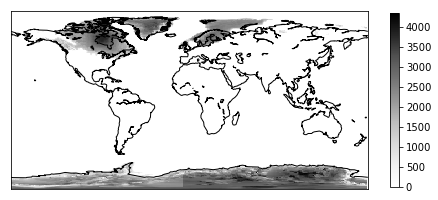

In [3]:
print('Ice at {0} cal ka BP'.format(sim.ice.times[41]))
plt.figure(figsize=(8,8))
sim.grid.pcolormesh(sim.ice[41], cmap='Greys'); plt.colorbar(shrink=0.4);
sim.grid.basemap.drawcoastlines();

Stored Topography


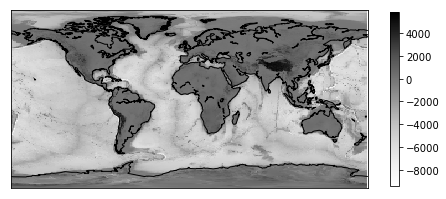

In [4]:
print('Stored Topography'.format(sim.ice.times[41]))
plt.figure(figsize=(8,8))
sim.grid.pcolormesh(sim.topo, cmap='Greys'); plt.colorbar(shrink=0.4);
sim.grid.basemap.drawcoastlines();

The center-piece of the software, though, is the function ```GiaSimGlobal.performConvolution```, which combines the loading history, earth model, and topography to compute the gravitationally self-consistent surface response with adaptive coast-lines. If the desired times of output for the simulation, ```out_times```, has not yet been set you can do so as an argument in the function. Here we compute the surface response at 12, 10, 8 cal ka BP and 100 years before and after present.

In [5]:
%%time
result = sim.performConvolution(out_times=[12, 10, 8, 0.1, 0, -0.1])

CPU times: user 29.3 s, sys: 32 ms, total: 29.4 s
Wall time: 29.4 s


The class function ```GiaSimGlobal.performConvolution``` combines the stored earth and ice models with an optional topgraphy to solve the full sea level equation, with consistently shifting coastlines and ocean loads (in response to viscoelastic perturbations of the surface and changing geoid heights). A solution is found for each time in ```ice.times``` (so that the uplift, geoid, etc. can affect the loads at these times). You can split the ice model into more times by changing the ice load in more than one step by setting the nrem keyword (untested).

The convolution outputs an object with arrays containing many variables of interest at many different times. Desired earth responses (uplift 'upl', gravity 'grav', geoid 'geo', rate of uplift 'vel') are calculated at the given output times and returned as spherical harmonic coefficients (which can be used tranformed using the stored harmonic transform as below). Variables from the creation of water loads are stored for all of the ice times on a grid matching ```grid```. Finally, the average ocean height changes (sometimes called Eustatic sea level, though this term needs careful consideration) are stored in 'esl'.

To recap, the result of ```GiaSimGlobal.performConvolution``` is an object that contains all the computed responses, as well as the inputs for recomputation. The object will typically have a series of "obesrvers," which are objects that contain specific results
- The solid surface topography (the surface of the solid earth at a time with respect to that time's sea level; useful for computing emergence) (```.sstopo```)
- the topography including ice heights (```.topo```)
- the incremental load (the cumulative sum of this is equivalent to the input ice model) (```.load```)
- the incremental ocean-load (```.wload```)
- uplift (```.upl```), gravity (```.grav```), geoid (```.geo```), horizontal deformations (```.hor```), vertical velocities (```.vel```) (These are in spectral form and need to be transformed)
- eustatic sea-level (```.esl```)


In [6]:
print(result)

GIA computed on 2017-07-17 18:24:19
Has observers: load, sstopo, upl, grav, topo, eslGeo, hor, wload, vel, esl, geo


Water load increment at 12 cal ka BP


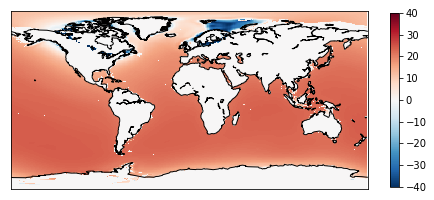

In [7]:
print('Water load increment at 12 cal ka BP')
plt.figure(figsize=(8,8))
result.inputs.grid.pcolormesh(result.wload[52], cmap='RdBu_r', vmin=-40, vmax=40); 
plt.colorbar(shrink=0.4);
sim.grid.basemap.drawcoastlines();

Uplift at 12 cal ka BP


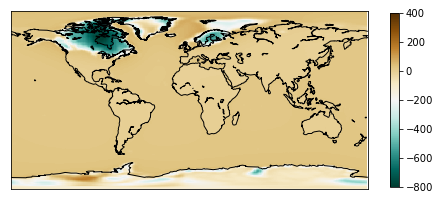

In [8]:
print('Uplift at 12 cal ka BP')
plt.figure(figsize=(8,8))
result.inputs.grid.pcolormesh(result.inputs.harmTrans.spectogrd(result.upl[0]), 
                                cmap='BrBG_r', vmin=-800, vmax=400); 
plt.colorbar(shrink=0.4);
sim.grid.basemap.drawcoastlines();

Emergence relative to present at 12 cal ka BP


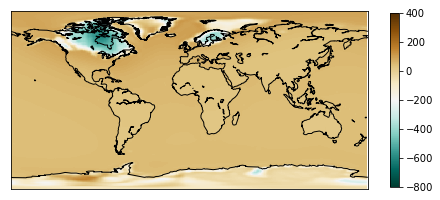

In [9]:
print('Emergence relative to present at 12 cal ka BP')
plt.figure(figsize=(8,8))
result.inputs.grid.pcolormesh(result.sstopo[52] - result.sstopo[-2], 
                              cmap='BrBG_r', vmin=-800, vmax=400); 
plt.colorbar(shrink=0.4);
sim.grid.basemap.drawcoastlines();

/home/skachuck/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/skachuck/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/skachuck/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/skachuck/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3707: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/skachuck/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3716: MatplotlibDeprecati

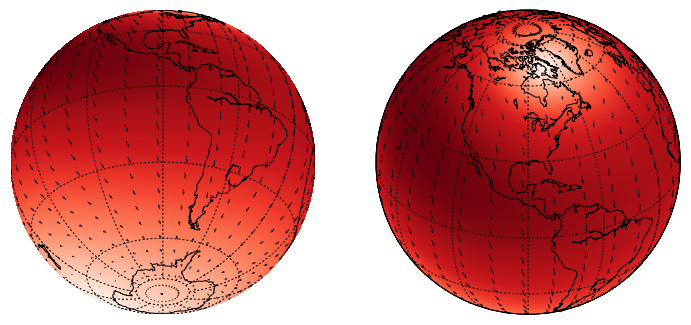

In [10]:
mtop = giapy.maps.Basemap(projection='ortho', lon_0=-90, lat_0=30)
mbottom = giapy.maps.Basemap(projection='ortho', lon_0=-90, lat_0=-30)
grid = sim.grid

tmpu, tmpv = sim.harmTrans.getuv(np.zeros(result.hor.array[0].T.shape), 
                                 result.hor.array[0].T)

uproj, vproj, X, Y = mbottom.rotate_vector(tmpu, tmpv, 
                                                    grid.Lon[0,:], grid.Lat[:,0],
                                                    returnxy=True)
skip = 10

fig, ax = plt.subplots(1,2,figsize=(12,12))
mbottom.drawmeridians(np.arange(0, 360, 30), ax=ax[0])
mbottom.drawparallels(np.arange(-90,90,30), ax=ax[0])
mbottom.drawcoastlines(ax=ax[0])
mbottom.pcolor(X, Y, np.sqrt(uproj**2 + vproj**2), cmap='Reds', ax=ax[0])
mbottom.quiver(X[::skip,::skip], Y[::skip,::skip], uproj[::skip,::skip], vproj[::skip,::skip], ax=ax[0])

uprojtop, vprojtop, Xtop, Ytop = mtop.rotate_vector(tmpu, tmpv, 
                                                    grid.Lon[0,:], grid.Lat[:,0],
                                                    returnxy=True)
mtop.drawmeridians(np.arange(0, 360, 30), ax=ax[1])
mtop.drawparallels(np.arange(-90,90,30), ax=ax[1])
mtop.drawcoastlines(ax=ax[1])
mtop.pcolor(Xtop, Ytop, np.sqrt(uprojtop**2 + vprojtop**2), cmap='Reds', ax=ax[1])
mtop.quiver(Xtop[::skip,::skip], Ytop[::skip,::skip], uprojtop[::skip,::skip], vprojtop[::skip,::skip], ax=ax[1]);

## Earth modelling

We generate a container for the earth's material parameters using ```EarthParams```. The container allows us to quickly determine the density, elastic properties, gravity, and viscosity at any depth in the mantle, and to communicate these for use in the viscoelastic equations of motion. Additionally, it allows us to quickly change the viscosity profile. By default it assumes the material properties of the Preliminary Reference Earth Model (Dziewonski & Anderson, 1981) and a uniform 10$^{21}$ Pa s viscosity profile.

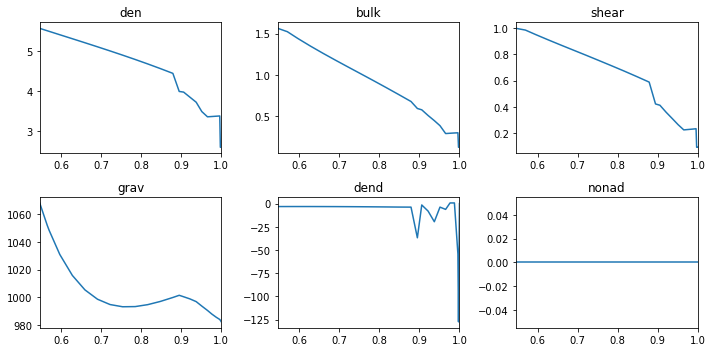

In [11]:
params = giapy.earth.earthParams.EarthParams()

fig, axs = plt.subplots(2,3, figsize=(10,5))
for ax, title, prof in zip(axs.flatten(), params._paramNames, params._paramArray):
    ax.plot(params.z, prof)
    ax.set_title(title)
    ax.set_xlim([params.rCore, 1.])
#axs[-1,-1].set_axis_off()
plt.tight_layout()

The parameters are as follows:
- ```den``` is Density, in g/cc
- ```bulk``` is Bulk Modulus, in $2.938 \times 10^{12}$ dyne cm$^{-2}$
- ```shear``` is Shear Modulus, in $2.938 \times 10^{12}$ dyne cm$^{-2}$
- ```grav``` is Gravitational Acceleration, in cm s$^{-2}$
- ```dend``` is Density Gradient, in g/cc / (normalized radius)
- ```nonad``` is the Nonadiabatic Density Gradient, in g/cc / (normalized radius)
- ```visc``` is the Viscosity, in $10^{22}$ poise

With these parameters, we calculate the elastic displacements, viscous velocities, and gravitational perturbations as the earth relaxes to a load of each order number up to 144 below. We provide an array of depths at which to calculate 

In [12]:
%%time
earth = giapy.earth.earthSpherical.SphericalEarth(params)
earth.calcResponse(np.linspace(params.rCore, 1, 50), nmax=144)

CPU times: user 27.6 s, sys: 8 ms, total: 27.7 s
Wall time: 27.7 s


In [13]:
tmp = giapy.earth.earthIntegrator.get_t0_guess(params, 
                                np.linspace(params.rCore, 1, 50))

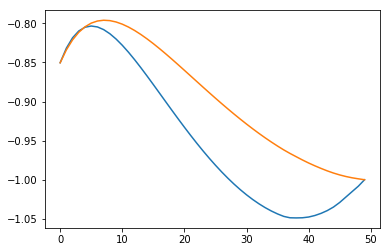

In [19]:
plt.plot(tmp[0][2])
plt.plot(tmp[1][2])

Below we plot the remaining viscous displacement to equilbirium from the time of application of a 1 dyne load till 12 ka.

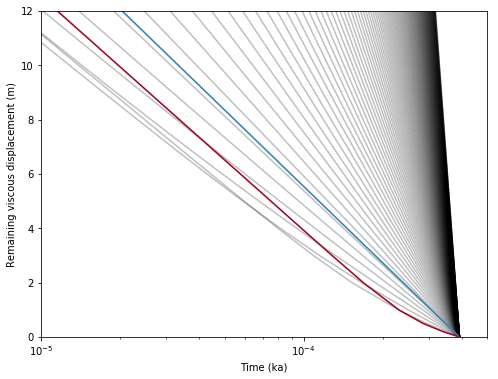

In [13]:
from giapy.plot_tools.earthPlot import plotViscDecay
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotViscDecay(earth, ax=ax, color='k', alpha=0.25);
plotViscDecay(earth, ax, 1, 2, color='#348ABD'); plotViscDecay(earth, ax, 2, 3, color='#A60628');

To add a lithosphere and a more interesting viscosity profile (including, say, an asthenosphere), generate a new EarthParams object with the ```visArray``` and ```D``` keywords filled with a viscous profile (in poise $= 10^{1}$ Pa s) and the lithospehre's flexural rigidity (in N m), respectively, or modify an existing EarthParams object. Below, the earth model is recalculated with a 75 km asthenosphere at $0.4\times10^{21}$ Pa s and a lithosphere of $4\times10^{23}$ N m. Below that, the decay lines are plotted (in red) to compare with the isoviscous earth relaxation (in black). The order numbers less than 10 are bolded for emphasis. Note how the low order numbers are unaffected by the addition of a lithosphere and asthenosphere, which is what we'd expect given that these order numbers generate flow through the entirety of the mantle. 

In [14]:
dAsth = 1. - 75e5/params.norms['r']
visArray = np.array([[params.rCore, dAsth, dAsth, 1.], [1e22, 1e22, 0.04e22, 0.04e22]])

paramsLithAsth = giapy.earth.earthParams.EarthParams(visArray=visArray, D=4e23)

earthLithAsth = giapy.earth.earthSpherical.SphericalEarth(paramsLithAsth)
z = np.r_[np.linspace(paramsLithAsth.rCore, dAsth, 30), np.linspace(dAsth, 1., 20)]
%time earthLithAsth.calcResponse(z, 144)

CPU times: user 41.3 s, sys: 4 ms, total: 41.3 s
Wall time: 41.3 s


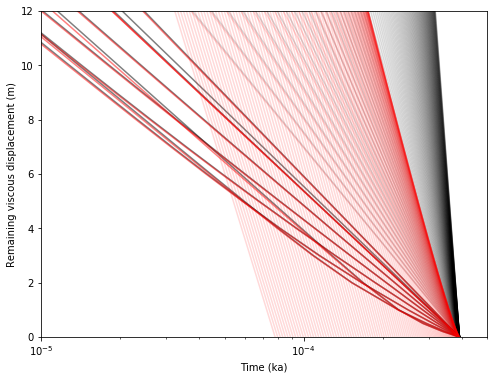

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
plotViscDecay(earth, ax=ax, color='k', alpha=0.5, nmin=1, nmax=10);
plotViscDecay(earthLithAsth, ax=ax, color='r', alpha=0.5, nmin=1, nmax=10);
plotViscDecay(earth, ax=ax, color='k', alpha=0.15, nmin=11, nmax=144);
plotViscDecay(earthLithAsth, ax=ax, color='r', alpha=0.15, nmin=11, nmax=144);

## Ice models

In [16]:
import giapy.icehistory as giaice

The ice model gives ice heights at each grid point on the globe for a number of time slices. There are two types of ice models that can be used - an ice model that stores the ice heights in external files and loads them in when needed (useful for very high resolution models that won't fit in memory); and one that stores the entire load in memory. Below we'll load in a model that I've previously read in from a high resolution model and turned into a lower resolution, persistent model for speed of computation.

This ice model has unique ice heights for thousand year slices from LGM (~23 ka BP) to present, but maps these heights to times during the glaciation (initiating ~120 ka BP) by matching volumes during deglaciation to times during glaciation with identidcal mean sea level (the Fairbanks curve).

In [17]:
ice = result.inputs.ice

The ```grid``` object assists with calculations involving globe geometries. It stores the ```basemap.Basemap``` object, assists with integrations on the sphere, and has some plotting capabilities. It is instantiated with either a basemap or basemap init keywords. For global model calculations, it must be an equiangular grid covering the entire globe, but for other purposes (plotting or interpolating results to other areas) it may be helpful to create others. It is also given a size, which needs to match the ice size. Below is plotted the LGM ice distribution over the globe.

In [18]:
import giapy.map_tools as giamap
grid = giamap.GridObject(mapparam={}, shape=(288,288))

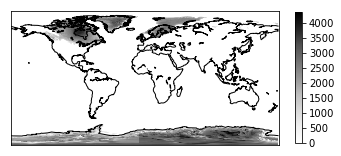

In [19]:
grid.pcolormesh(ice[41], cmap='Greys'); plt.colorbar(shrink=0.6);
grid.basemap.drawcoastlines();

The important things that make an ice model are heights, times, and a method for iterating over them. Specifically, to allow for efficiently loading large ice load files, the convolution described below relies on a method, ```pairIter```, that iterates over consecutive pairs of ice stages.